# BERT Prediction Error Analysis

As the result of text classification by 3 types of BERT models ( BERT_BASED_UNCASED, BERT_LARGE_UNCASED, DISTILBERT), it is found that:
 - The smaller the model is, the higher the accuracies. Distilbert achieved 77.8% in contrast that Bert_large_uncased only achieved 70& around.

In order to improve the accuracy level, we will perform the further study on those records whose prediction result are wrong, and see whether there are some ways.

Given Bert_large_uncased does not achieved high accuracy, in order to save the potential efforts, we take the remaining 2 models for the error analysis.

In [1]:
import warnings
# Disable 3 types of warning
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=(FutureWarning))
warnings.filterwarnings("ignore",category=(RuntimeWarning))

##### import error data

In [2]:
import pandas as pd

# import bert error data
error_data_0_path="./tmp/test_error2022-09-29.csv"
error_data_0=pd.read_csv(error_data_0_path)
# import distilbert data
error_data_1_path="./tmp/test_error_distillbert_2022-10-06.csv"
error_data_1=pd.read_csv(error_data_1_path)

# Pick up the common error data
error_data=error_data_1.merge(right=error_data_0,how="inner",on=['original_text'])

In [3]:
error_data.head()

,Unnamed: 0_x,original_text,label_x,Unnamed: 0_y,label_y
0,2,Military bases Virginia Beach is home to sever...,0,932,0
1,9,The success of the first event enabled its pro...,0,4361,0
2,13,"In 1963 , the CMA announced that a Country Mus...",1,2691,1
3,28,URM.edu,1,1698,1
4,41,FlÃ rez was married to German-born Julia Trapp...,0,9366,0


Text(0.5, 1.0, 'Distribution of original text length in words')

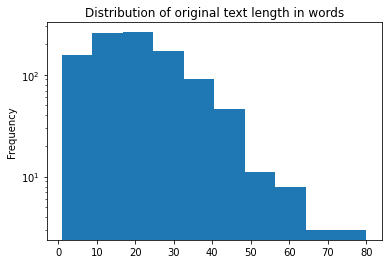

In [4]:
import matplotlib.pyplot as plt
# TRAIN SET 
error_data['original_text'].apply(lambda x: len(x.split())).plot(kind='hist');
plt.yscale('log');
plt.title('Distribution of original text length in words')

In [5]:
error_data['original_text'].apply(lambda x: len(x.split())).describe()

count    1009.000000
mean       20.440040
std        12.881813
min         1.000000
25%        12.000000
50%        19.000000
75%        27.000000
max        80.000000
Name: original_text, dtype: float64

In [6]:
error_data

,Unnamed: 0_x,original_text,label_x,Unnamed: 0_y,label_y
0,2,Military bases Virginia Beach is home to sever...,0,932,0
1,9,The success of the first event enabled its pro...,0,4361,0
2,13,"In 1963 , the CMA announced that a Country Mus...",1,2691,1
3,28,URM.edu,1,1698,1
4,41,FlÃ rez was married to German-born Julia Trapp...,0,9366,0
...,...,...,...,...,...
1004,9544,"She grew up in Basildon , where she attended s...",0,4234,0
1005,9548,Its official nickname is the '' Socceroos '' .,1,3170,1
1006,9551,"In late 1990 , shortly after the band 's first...",0,7747,0
1007,9590,The language is thousand 's of years old .,1,10278,1


### Rerun the prediction to confirm the errors

In [7]:
import logging
import numpy as np

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

#MAX_SEQ_LENGTH=100
MAX_SEQ_LENGTH=80

class BertInputItem(object):
    """An item with all the necessary attributes for finetuning BERT."""

    def __init__(self, text, input_ids, input_mask, segment_ids, label_id):
        self.text = text
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id
        

def convert_examples_to_inputs(example_texts, example_labels, label2idx, max_seq_length, tokenizer):
    """Loads a data file into a list of `InputBatch`s."""
    
    input_items = []
    examples = zip(example_texts, example_labels)
    for (ex_index, (text, label)) in enumerate(examples):

        # Create a list of token ids
        input_ids = tokenizer.encode(f"[CLS] {text} [SEP]")
        if len(input_ids) > max_seq_length:
            input_ids = input_ids[:max_seq_length]

        # All our tokens are in the first input segment (id 0).
        segment_ids = [0] * len(input_ids)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        label_id = label2idx[label]

        input_items.append(
            BertInputItem(text=text,
                          input_ids=input_ids,
                          input_mask=input_mask,
                          segment_ids=segment_ids,
                          label_id=label_id))

        
    return input_items


In [8]:
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

def get_data_loader(features, max_seq_length, batch_size, shuffle=True): 

    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

    #dataloader = DataLoader(data, shuffle=shuffle, batch_size=batch_size)
    # dataloader tuning in https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html
   
    dataloader = DataLoader(data, shuffle=shuffle, batch_size=batch_size,num_workers=2,pin_memory=True)
    return dataloader

BATCH_SIZE = 16

In [17]:
def evaluate(model, dataloader):
    model.eval()
    
    eval_loss = 0
    nb_eval_steps = 0
    predicted_labels, correct_labels = [], []

    for step, batch in enumerate(tqdm(dataloader, desc="Evaluation iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        with torch.no_grad():
            #tmp_eval_loss, logits = model(input_ids, attention_mask=input_mask,
            #                              token_type_ids=segment_ids, labels=label_ids)[:2]
            tmp_eval_loss, logits = model(input_ids, attention_mask=input_mask,
                                         labels=label_ids)[:2]  # for distilbert
        outputs = np.argmax(logits.to('cpu'), axis=1)
        label_ids = label_ids.to('cpu').numpy()
        
        predicted_labels += list(outputs)
        correct_labels += list(label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    
    correct_labels = np.array(correct_labels)
    predicted_labels = np.array(predicted_labels)
        
    return eval_loss, correct_labels, predicted_labels

In [88]:
import torch
from transformers import BertForSequenceClassification,DistilBertForSequenceClassification
from transformers import BertTokenizer,DistilBertTokenizer
import os
from sklearn.metrics import classification_report, precision_recall_fscore_support

# Evaluate the dataset based on trained distilbert model
def data_evaluation(texts,labels,OUTPUT_DIR = "./tmp/", MODEL_FILE_NAME = "pytorch_model.bin"):
    # Convert test data of submission to features
    target_names = list(set(labels))
    label2idx = {label: idx for idx, label in enumerate(target_names)}
    
    # Enable GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Select bert model
    BERT_MODEL = "distilbert-base-uncased"
    tokenizer = DistilBertTokenizer.from_pretrained(BERT_MODEL)
    
    # Using trained model
    model_state_dict = torch.load(os.path.join(OUTPUT_DIR, MODEL_FILE_NAME), map_location=lambda storage, loc: storage)
    model=DistilBertForSequenceClassification.from_pretrained(BERT_MODEL, state_dict=model_state_dict, num_labels = len(target_names),
                                                              ignore_mismatched_sizes=True)
    model.to(device)
    
    # Convert text and labels to embeddings 
    features = convert_examples_to_inputs(texts, labels, label2idx, MAX_SEQ_LENGTH, tokenizer)
    dataloader = get_data_loader(features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)
    
    # Predict the result, and discard the evaluatoin result, only take the prediction result.
    _, correct, predicted = evaluate(model, dataloader)
    print("Errors performance:", precision_recall_fscore_support(correct, predicted, average="micro"))

    #bert_accuracy = np.mean(predicted == correct)
    
    #print(bert_accuracy)
    print(classification_report(correct, predicted))

    return correct,predicted 

In [33]:
# Confirm the error data should not be predicted correctly.
texts=list(error_data["original_text"])
labels=list(error_data["label_x"])
data_evaluation(texts,labels)

Evaluation iteration:   0%|          | 0/64 [00:00<?, ?it/s]

Errors performance: (0.0, 0.0, 0.0, None)
0.0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     714.0
           1       0.00      0.00      0.00     295.0

    accuracy                           0.00    1009.0
   macro avg       0.00      0.00      0.00    1009.0
weighted avg       0.00      0.00      0.00    1009.0



(array([0, 0, 1, ..., 0, 1, 0], dtype=int64),
 array([1, 1, 0, ..., 1, 0, 1], dtype=int64))

#### Spelling error correction

In [45]:
# correct spelling error to check whether accuracy could be improved.
from textblob import TextBlob
error_data['correct_text_0'] = error_data['original_text'].apply(lambda x :TextBlob(x).correct())

In [34]:
texts=list(error_data["correct_text_0"])
labels=list(error_data["label_x"])
data_evaluation(texts,labels)

Evaluation iteration:   0%|          | 0/64 [00:00<?, ?it/s]

Errors performance: (0.0981169474727453, 0.0981169474727453, 0.0981169474727453, None)
0.0981169474727453
              precision    recall  f1-score   support

           0       0.25      0.13      0.17       714
           1       0.00      0.01      0.01       295

    accuracy                           0.10      1009
   macro avg       0.13      0.07      0.09      1009
weighted avg       0.18      0.10      0.13      1009



(array([0, 0, 1, ..., 0, 1, 0], dtype=int64),
 array([0, 1, 0, ..., 1, 0, 1], dtype=int64))

##### The above result suggests spelling check could improve 13% accuracy, however, the performance of spelling check is not encouraging.

In [23]:
#error_data.to_csv("./tmp/error_data_20221006.csv",index=False) # export error data to csv for manual check

#### Clean text to see whether that would improve accuracy

In [41]:
import string
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [42]:
error_data['clean_text'] = error_data['original_text'].apply(lambda x:clean_text(x))

In [44]:
texts=list(error_data["clean_text"])
labels=list(error_data["label_x"])
data_evaluation(texts,labels)

Evaluation iteration:   0%|          | 0/64 [00:00<?, ?it/s]

Errors performance: (0.2556987115956392, 0.2556987115956392, 0.2556987115956392, None)
              precision    recall  f1-score   support

           0       0.46      0.33      0.39       714
           1       0.04      0.07      0.05       295

    accuracy                           0.26      1009
   macro avg       0.25      0.20      0.22      1009
weighted avg       0.34      0.26      0.29      1009



(array([0, 0, 1, ..., 0, 1, 0], dtype=int64),
 array([1, 1, 0, ..., 0, 0, 1], dtype=int64))

In [77]:
from text_preprocessing import preprocess_text
from text_preprocessing import to_lower, remove_punctuation,remove_special_character,normalize_unicode,check_spelling,remove_stopword,lemmatize_word
# Preprocess text using custom preprocess functions in the pipeline 
STOPWORDS=['-RRB-','-LRB-'] # remove customized stopwords
preprocess_functions = [to_lower, remove_punctuation,remove_special_character,normalize_unicode,remove_stopword,lemmatize_word]
error_data['preprocess_text'] = error_data['original_text'].apply(lambda x:' '.join(remove_stopword(preprocess_text(x,preprocess_functions),
                                                                                          stop_words=STOPWORDS)))

In [78]:
error_data

,Unnamed: 0_x,original_text,label_x,Unnamed: 0_y,label_y,correct_text_0,clean_text,preprocess_text
0,2,Military bases Virginia Beach is home to sever...,0,932,0,"(M, i, l, i, t, a, r, y, , b, a, s, e, s, , ...",military bases virginia beach is home to sever...,military base virginia beach home several unit...
1,9,The success of the first event enabled its pro...,0,4361,0,"(T, h, e, , s, u, c, c, e, s, s, , o, f, , ...",the success of the first event enabled its pro...,success first event enabled promoter hold regu...
2,13,"In 1963 , the CMA announced that a Country Mus...",1,2691,1,"(I, n, , 1, 9, 6, 3, , ,, , t, h, e, , C, ...",in the cma announced that a country music ha...,1963 cma announced country music hall fame mus...
3,28,URM.edu,1,1698,1,"(U, R, M, ., e, d)",urmedu,urmedu
4,41,FlÃ rez was married to German-born Julia Trapp...,0,9366,0,"(a, l, l, , r, e, d, , w, a, s, , m, a, r, ...",flã rez was married to germanborn julia trappe...,fla rez married germanborn julia trappe privat...
...,...,...,...,...,...,...,...,...
1004,9544,"She grew up in Basildon , where she attended s...",0,4234,0,"(T, h, e, , g, r, e, w, , u, p, , i, n, , ...",she grew up in basildon where she attended sc...,grew basildon attended school
1005,9548,Its official nickname is the '' Socceroos '' .,1,3170,1,"(I, t, s, , o, f, f, i, c, i, a, l, , n, i, ...",its official nickname is the socceroos,official nickname socceroos
1006,9551,"In late 1990 , shortly after the band 's first...",0,7747,0,"(I, n, , l, a, t, e, , 1, 9, 9, 0, , ,, , ...",in late shortly after the band s first world...,late 1990 shortly band first worldwide tour so...
1007,9590,The language is thousand 's of years old .,1,10278,1,"(T, h, e, , l, a, n, g, u, a, g, e, , i, s, ...",the language is thousand s of years old,language thousand year old


In [79]:
texts=list(error_data["preprocess_text"])
labels=list(error_data["label_x"])
data_evaluation(texts,labels)

Evaluation iteration:   0%|          | 0/64 [00:00<?, ?it/s]

Errors performance: (0.4132804757185332, 0.4132804757185332, 0.41328047571853316, None)
              precision    recall  f1-score   support

           0       0.60      0.53      0.56       714
           1       0.10      0.13      0.12       295

    accuracy                           0.41      1009
   macro avg       0.35      0.33      0.34      1009
weighted avg       0.45      0.41      0.43      1009



(array([0, 0, 1, ..., 0, 1, 0], dtype=int64),
 array([0, 0, 0, ..., 0, 0, 1], dtype=int64))

#### The accuracy of error list was improved to 45%, and it looks like the preprocessing text do help to improve accuracy. 

##### Given the above improvement, and try to apply this to test set

In [80]:
# Loading the test data for submission
sub_data_path="./01_data/WikiLarge_Test.csv"
sub_data=pd.read_csv(sub_data_path)

In [81]:
 sub_data['original_text'] = sub_data['original_text'].apply(lambda x:' '.join(remove_stopword(preprocess_text(x,preprocess_functions),
                                                                                          stop_words=STOPWORDS)))

In [82]:
sub_texts=list(sub_data["original_text"])
sub_labels=[1 for i in range(len(sub_texts))]

print("Submission Test size:", len(sub_data))

Submission Test size: 119092


In [89]:
_, sub_predicted=data_evaluation(sub_texts,sub_labels)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([1, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluation iteration:   0%|          | 0/7444 [00:00<?, ?it/s]

Errors performance: (1.0, 1.0, 1.0, None)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    119092

    accuracy                           1.00    119092
   macro avg       1.00      1.00      1.00    119092
weighted avg       1.00      1.00      1.00    119092



In [90]:
# Produce the submission file
df_sub=pd.DataFrame(columns=["id","label"])
df_sub['label']=sub_predicted
df_sub['id']=[i for i in range(len(sub_predicted))]
df_sub.to_csv("./tmp/submission.csv",index=False)

### Embedding-based clustering analysis

In [6]:
# Other utils
from tqdm import tqdm  # Progress bar
# Transformers
from transformers import pipeline
import ipywidgets as widgets
from transformers import pipeline
from sentence_transformers import SentenceTransformer

In [7]:
#onlinemodel='distiluse-base-multilingual-cased-v2'
onlinemodel="all-mpnet-base-v2"
embedder = SentenceTransformer(onlinemodel)

In [ ]:
queries= list(error_data['original_text'])
query_embeddings=embedder.encode(queries)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Elbow criterion - Determine optimal numbers of clusters by elbow rule.
def elbow_plot(data, maxK=15, seed_centroids=None):
    """
        parameters:
        - data: pandas DataFrame (data to be fitted)
        - maxK (default = 10): integer (maximum number of clusters with which to run k-means)
        - seed_centroids (default = None ): float (initial value of centroids for k-means)
    """
    sse = []
    K= range(1, maxK)
    for k in K:
        if seed_centroids is not None:
            seeds = seed_centroids.head(k)
            kmeans = KMeans(n_clusters=k, max_iter=500, n_init=100, random_state=0, init=np.reshape(seeds, (k,1))).fit(data)
            #data["clusters"] = kmeans.labels_
        else:
            kmeans = KMeans(n_clusters=k, max_iter=300, n_init=100, random_state=0).fit(data)
            #data["clusters"] = kmeans.labels_
        print("k: ", k,"sse: ",kmeans.inertia_)
        # Inertia: Sum of distances of samples to their closest cluster center
        sse.append(kmeans.inertia_)
    plt.figure()
    plt.plot(K,sse,'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()
    return kmeans.labels_

In [ ]:
# Run Elbow for full training data
elbow_plot(query_embeddings)

In [ ]:
# Create clustering dataframe 
def df_clustering(queries, embeddings, labels=None, clusters=2):
    """
        parameters:
        - queries: list of queries
        - embeddings: list of embeddings corresponding to queries
        - clusters: no. of clusters for kmeans
    """
    num_clusters = clusters
    clf = KMeans(n_clusters=num_clusters, 
                max_iter=100, 
                init='k-means++', 
                n_init=1)
    clf.fit_predict(embeddings)
    cluster_assignment = clf.labels_

    cdf=pd.DataFrame(columns=["cluster_id","sentence_id","sentence",'label'])

    cdf['cluster_id']=clf.labels_
    cdf['sentence_id']=[i for i in range(len(clf.labels_))]
    cdf['sentence']=queries
    cdf['label']=labels
                                            
    return cdf

In [ ]:
num_clusters = 4
clf = KMeans(n_clusters=num_clusters, 
            max_iter=100, 
            init='k-means++', 
            n_init=1)
clf.fit_predict(query_embeddings)
cluster_assignment = clf.labels_

cdf=pd.DataFrame(columns=["cluster_id","sentence_id","sentence"])

for i in range(len(cluster_assignment)):
    new_row=pd.DataFrame({"cluster_id":[cluster_assignment[i]],
                                "sentence_id":[i],
                                "sentence":[queries[i]]
                           })
    cdf=pd.concat([cdf,new_row],axis=0,ignore_index=True)

cdf.head()

In [ ]:
# Using PCA to reduce the dimension to project the result to 2-d scatter plot
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(query_embeddings)

df_pca = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

df_pca['sentence']=queries
# Combine PCA results with K-means results to see clustering
df_k=df_pca.merge(cdf,right_on=['sentence'],left_on=['sentence'])

In [ ]:
fig, ax = plt.subplots()
ls_clusters=pd.unique(df_k["cluster_id"])
ls_colors=['tab:blue', 'tab:orange', 'tab:green','tab:purple']
#ls_colors=df_k["cluster_id"].astype('category').cat.codes
for id in range(len(ls_clusters)):
    ax.scatter(df_k[df_k['cluster_id']==ls_clusters[id]]['principal component 1'],
               df_k[df_k['cluster_id']==ls_clusters[id]]['principal component 2'], c=ls_colors[id], label=ls_clusters[id],
               alpha=0.9, edgecolors='none')

ax.legend()
ax.grid(True)

plt.show()